## DATA VISUALISATION TOOL & THE MODELS

1. Stock data visualisation tool 
   
   1. closing price
   2. opening price
   3. volume


2. The models 
   
   1. ets model
   2. linear regression
   3. arima model
   

#### 1. Stock data visualisation tool

##### How the tool works:

    - User will input the number of stocks they want to see 
    - User will then input respective ticker symbols 
    - Tool will generate three interactive plots (stock opening price, stock closing price & stock volume) over a 5 year range

In [30]:
# import libraries 

import yfinance as yf
import pandas as pd
import plotly.express as px
import random 
import plotly.io as pio
from plotly.offline import init_notebook_mode
import matplotlib.pyplot as plt
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
import warnings
from IPython.display import display
from sklearn.linear_model import LinearRegression
warnings.filterwarnings('ignore')
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.stattools import adfuller 
import pmdarima as pm

# fixes for GitHub and Plotly
init_notebook_mode(connected = True)
pio.renderers.default = 'notebook_connected'

In [31]:
# get the dataset and prepare it function

def get_and_prep_dataset(list_of_tickers, call_num):

    # get ticker symbol from list of tickers from user
    set_ticker = list_of_tickers[call_num]

    # get ticker from Yahoo Finance API
    ticker = yf.Ticker(set_ticker)

    # get historical data - 5yr range 
    from_yahoo = ticker.history(period = '5y')

    # set raw_dataset variable 
    raw_dataset = from_yahoo

    # series holding opening prices
    df_op = raw_dataset['Open']

    # series holding closing prices
    df_ser = raw_dataset['Close']
    
    # series holding volume
    df_volume_ser = raw_dataset['Volume']

    # convert series to pandas dataframes 
    df_ = pd.DataFrame(df_op)
    df_.index.name = None # fix for the two rows for column header issue
    df_.reset_index(level = 0, inplace = True)
    df_.rename(columns = {'index' : 'Date'}, inplace = True)

    df = pd.DataFrame(df_ser)
    df.index.name = None 
    df.reset_index(level = 0, inplace = True)
    df.rename(columns = {'index' : 'Date'}, inplace = True)

    df_volume = pd.DataFrame(df_volume_ser)
    df_volume.index.name = None 
    df_volume.reset_index(level = 0, inplace = True)
    df_volume.rename(columns = {'index' : 'Date'}, inplace = True)

    # set name variable from dictionary of company info
    name = ticker.info['longName']

    # set ticker symbol variable from dictionary of company info
    ticker_symbol = ticker.info['symbol']

    return df_, df, df_volume, name, ticker_symbol, ticker, raw_dataset


In [32]:
# information function 

def get_company_info(ticker):

    # information for ETFs
    if ticker.info['quoteType'] == 'ETF':
        print(' ')
        print('Stock: '  + ticker.info['longName'])
        print(' ')
        print('//////////////////////////////////////////////////////////////////////////////////////////////////////////////')  
        print(' ')  
        print('Ticker Symbol: ' + ticker.info['symbol'])
        print('Type: Exchange Traded Fund (ETF)')
        print('Fund Family: ' + ticker.info['fundFamily'])
        print('Total Number of Assets: ' + str(ticker.info['totalAssets']))
        print(' ')
        print('Summary: ' + ticker.info['longBusinessSummary'])
        print(' ')
        print('//////////////////////////////////////////////////////////////////////////////////////////////////////////////')   
        print(' ')
        holdings = ticker.info['holdings']
        heading = '{} : {} : {}'.format('SYMBOL', 'HOLDING NAME', 'HOLDING PERCENT')
        print(heading)
        print(' ')
        for i in range(len(holdings)):
            result = '{} : {} : {}'.format(holdings[i]['symbol'], holdings[i]['holdingName'], holdings[i]['holdingPercent'])
            print(result)
        print('\n')

    # information for equities 
    elif ticker.info['quoteType'] == 'EQUITY':  
        print(' ') 
        print('Stock: '  + ticker.info['longName'])
        print(' ')
        print('//////////////////////////////////////////////////////////////////////////////////////////////////////////////')  
        print(' ')
        print('Ticker Symbol: ' + ticker.info['symbol'])
        print('Industry: ' + ticker.info['industry'])
        print('Address: ' + ticker.info['address1'] + ', ' + ticker.info['city'] + ', ' + ticker.info['state'] + ', ' + ticker.info['country'])
        print(' ')
        print('Summary: ' + ticker.info['longBusinessSummary'])
        print(' ')
        print('//////////////////////////////////////////////////////////////////////////////////////////////////////////////')  
        print(' ')
        print('Profit Margin: ' + str(ticker.info['profitMargins']))
        print('Total Revenue: $' + str(ticker.info['totalRevenue']))
        print('Total Cash: $' + str(ticker.info['totalCash']))
        print('Total Debt: $' + str(ticker.info['totalDebt']))
        print('Debt to Equity: ' + str(ticker.info['debtToEquity']))
        print('Operating Cashflow: $' + str(ticker.info['operatingCashflow']))
        print('52 Week Change: ' + str(ticker.info['52WeekChange']))
        print('\n')
    

In [33]:
# visualisation function

def show_visual(df_, df, df_volume, name, ticker_symbol):
    
    # holds all colors that will be used 
    all_colors = ['blue', 'orange', 'red', 'green', 'purple', 'brown', 'violet', 'pink', 'darkgoldenrod', 'black', 'teal', 'gold']

    # visualise stock price at opening
    fig = px.line(df_, x = 'Date', y = 'Open', title = '<b>' + name + ' (' + ticker_symbol + ')' + '</b>' + ' - Stock Price (Open)', labels = {'value' : 'Open Price', 'Open' : 'Open Price ($)'})

    fig.update_layout(height = 575)
    fig.update_traces(hovertemplate = 'Date: %{x} <br>Open Price: $%{y}', line_color = random.choice(all_colors))

    fig.show()

    # visualise stock price at closing
    fig = px.line(df, x = 'Date', y = 'Close', title = '<b>' + name + ' (' + ticker_symbol + ')' + '</b>' + ' - Stock Price (Close)', labels = {'value' : 'Close Price', 'Close' : 'Close Price ($)'})

    fig.update_layout(height = 575)
    fig.update_traces(hovertemplate = 'Date: %{x} <br>Close Price: $%{y}', line_color = random.choice(all_colors))

    fig.show()

    # visualise stock volume at closing
    fig_v = px.area(df_volume, x = 'Date', y = 'Volume', title = '<b>' + name + ' (' + ticker_symbol + ')' + '</b>' + ' - Stock Volume', labels = {'value' : 'Volume', 'Volume' : 'Volume (M)'})

    fig_v.update_layout(height = 575)
    fig_v.update_traces(hovertemplate = 'Date: %{x} <br>Volume: %{y}', line_color = random.choice(all_colors))

    fig_v.show()


#### 2. The models

    - User will input the number of stocks they want to see 
    - User will then input respective ticker symbols 
    - See model results

##### 1. ETS model

    - Forecasts opening price for the next 14 records

In [34]:
# EDA 

def see_data(df_):

    # see missing data, if any
    print('Number of missing data records from Open: ' + str(sum(df_['Open'].isna())))
    print('Number of missing data records from Date: ' + str(sum(df_['Date'].isna())))

    print('\n')

    # see info
    print(df_.info())
    

In [35]:
# secondary plots - in matplotlib 

def secondary_visualizations(df_, ticker):
    
    # constructing the visualisation
    plt.figure(figsize = (15, 8))

    plt.plot(df_['Date'], df_['Open'], label = 'Open Price History')
    plt.title(str(ticker.info['longName']) + ' (' + str(ticker.info['symbol']) + ')', fontweight = 'bold')
    plt.xlabel('Date')
    plt.ylabel('Open Price ($)')
    
    plt.show()
    

In [36]:
# the ets model 

def the_etsmodel(df_):

    open_price = df_['Open'].values.tolist()

    dte = df_['Date'].dt.strftime('%m-%d-%Y')
    dte = dte.values.tolist()

    price = pd.Series(open_price, index = dte)

    model = ETSModel(price, error = 'add', trend = 'add', seasonal = None, damped_trend = True)
    
    fit = model.fit()

    print(fit.summary())

    # model's fit 
    plt.figure(figsize = (10, 6))
    plt.title('Fit against the data')
    price.plot(label = 'original', color = 'black', linestyle = 'solid')
    fit.fittedvalues.plot(label = 'model fit', linestyle = 'dotted', color = 'orange')
    plt.xlabel('Date')
    plt.ylabel('Open Price ($)')
    plt.legend()
    plt.show()

    # prediction range - next 14 records
    start_rec = len(price)
    end_rec = start_rec + 14

    forecast = fit.get_prediction(start = start_rec, end = end_rec)

    fc_result = forecast.summary_frame(alpha = 0.05)

    display(fc_result)

    plt.figure(figsize = (10, 6))
    plt.title('Forecasts')
    fc_result['mean'].plot(label = 'mean', color = 'red')
    fc_result['pi_lower'].plot(label = '95% prediction interval (lower band)', linestyle = 'dotted', color = 'blue')
    fc_result['pi_upper'].plot(label = '95% prediction interval (upper band)', linestyle = 'dotted', color = 'blue')
    price.plot(label = 'original', linestyle = 'solid', color = 'black')
    plt.xlabel('Date')
    plt.ylabel('Open Price ($)')
    plt.legend()
    plt.show()


##### 2. linear regression model

    - predicts closing price based on opening price

In [37]:
# EDA 

def see_data_lr(raw_dataset, df_):

    # see missing data, if any
    print('Number of missing data records from Open: ' + str(sum(raw_dataset['Open'].isna())))
    print('Number of missing data records from Close: ' + str(sum(raw_dataset['Close'].isna())))
    print('Number of missing data records from Date: ' + str(sum(df_['Date'].isna())))

    print('\n')

    # see info
    print(raw_dataset.info())
    

In [38]:
# secondary plots - in matplotlib 

def secondary_visualizations_lr(raw_dataset, df_, ticker):
    
    # constructing the visualisation
    plt.figure(figsize = (15, 8))

    plt.plot(df_['Date'], raw_dataset['Open'], label = 'Open Price History')
    plt.plot(df_['Date'], raw_dataset['Close'], label = 'Close Price History')
    plt.title(str(ticker.info['longName']) + ' (' + str(ticker.info['symbol']) + ')', fontweight = 'bold')
    plt.xlabel('Date')
    plt.ylabel('Price ($)')
    plt.legend()
    
    plt.show()
    

In [39]:
# the linear regression model 

def lreg_model(raw_dataset, ticker):

    X = raw_dataset['Open']
    y = raw_dataset['Close']

    X = X.values.tolist()
    y = y.values.tolist()

    X = np.array(X)
    y = np.array(y)

    X = X.reshape(-1, 1)
    y = y.reshape(-1, 1)

    mod = LinearRegression()
    mod.fit(X, y)

    prompt_res = []
    prompt = input('YES/NO: Do you know the opening price for {} from the previous trading day? '.format(str(ticker.info['symbol'])))
    prompt_res.append(prompt.upper())

    if prompt_res[0] == 'YES':
        prompt2 = input('Enter the opening price for {} from the previous trading day (without the $): '.format(str(ticker.info['symbol'])))
        X_fc = [prompt2]
    else:
        X_fc = [raw_dataset['Close'].iloc[-10].mean()]

    X_fc = np.array(X_fc)
    X_fc = X_fc.reshape(-1, 1)

    y_fc = mod.predict(X_fc)

    predicted_price = y_fc.flat[0]

    # prediction
    print('Predicted Closing Price for {} -> ${}'.format(str(ticker.info['longName']), round(predicted_price, 4)))

    XX_train, XX_test, yy_train, yy_test = train_test_split(X, y, test_size = 0.20)

    mmodel = LinearRegression()

    mmodel.fit(XX_train, yy_train)

    y_pr = mmodel.predict(XX_test)

    # evaluation
    r2 = r2_score(yy_test, y_pr)
    mae = mean_absolute_error(yy_test, y_pr)
    itcept = mmodel.intercept_.flat[0]
    coef = mmodel.coef_.flat[0]

    print('\n')
    print('Closing Price = {} + {} * Opening Price'.format(round(itcept, 4), round(coef, 4)))
    print('The R^2: {}'.format(round(r2, 4)))
    print('The MAE: {}'.format(round(mae, 4)))

    plt.figure(figsize = (15, 8))

    plt.scatter(XX_test, yy_test, color = 'red', label = 'observed values')
    plt.plot(XX_test, y_pr, label = 'predicted values')
    plt.title(str(ticker.info['longName']) + ' (' + str(ticker.info['symbol']) + ')', fontweight = 'bold')
    plt.xlabel('Price ($)')
    plt.ylabel('Price ($)')
    plt.legend()
    
    plt.show()
    

#### 3. arima model

In [40]:
# EDA

def see_data_ar(df):

    # see missing data, if any
    print('Number of missing data records from Open: ' + str(sum(df['Close'].isna())))
    print('Number of missing data records from Date: ' + str(sum(df['Date'].isna())))

    print('\n')

    # see info
    print(df.info())
    

In [41]:
# secondary plots - in matplotlib 

def secondary_visualizations_ar(df, ticker):
    
    # constructing the visualisation
    plt.figure(figsize = (15, 8))
    plt.plot(df['Date'], df['Close'], label = 'Close Price History')
    plt.title(str(ticker.info['longName']) + ' (' + str(ticker.info['symbol']) + ')', fontweight = 'bold')
    plt.xlabel('Date')
    plt.ylabel('Close Price ($)')
    plt.show()
    

In [42]:
# the arima model

def the_arima(df):

    # stationarity test
    test_results = adfuller(df['Close'])
    
    print('The null hypothesis (H0) is the data is NOT stationary')
    print('\n')
    print('p-value = {}'.format(round(test_results[1], 4)))
    print('lags used = {}'.format(test_results[2]))
    print('num of obs = {}'.format(test_results[3]))
    print('\n')

    if test_results[1] <= 0.05:
        print('There is significant evidence against the null, as a result H0 is rejected and the data is stationary')
        print('\n')
        stationary_data = df['Close'].dropna()
    else:
        print('There is not enough evidence to reject the null and the data is NOT stationary')
        print('\n')
        df['Close 1st Diff'] = df['Close'] - df['Close'].shift(1)
        df['Close Seasonal Diff'] = df['Close'] - df['Close'].shift(12)

        test_results_sea = adfuller(df['Close Seasonal Diff'].dropna())

        print('p-value = {}'.format(round(test_results_sea[1], 4)))
        print('lags used = {}'.format(test_results_sea[2]))
        print('num of obs = {}'.format(test_results_sea[3]))
        print('\n')

        if test_results_sea[1] <= 0.05: 
            print('There is significant evidence against the null, as a result H0 is rejected and the data after 1st differencing is stationary')
            print('\n')
            stationary_data = df['Close Seasonal Diff'].dropna()
        else:
            print('There is not enough evidence to reject the null and the data is NOT stationary')
            print('\n')
            
            test_results_1st = adfuller(df['Close 1st Diff'].dropna())

            print('p-value = {}'.format(round(test_results_1st[1], 4)))
            print('lags used = {}'.format(test_results_1st[2]))
            print('num of obs = {}'.format(test_results_1st[3]))
            print('\n')

            if test_results_1st[1] <= 0.05: 
                print('There is significant evidence against the null, as a result H0 is rejected and the data after 1st differencing is stationary')
                print('\n')
                stationary_data = df['Close 1st Diff'].dropna()
            else:
                print('There is not enough evidence to reject the null and the data is NOT stationary')
                print('\n')

                test_results_sea = adfuller(df['Close Seasonal Diff'].dropna())

                print('p-value = {}'.format(round(test_results_sea[1], 4)))
                print('lags used = {}'.format(test_results_sea[2]))
                print('num of obs = {}'.format(test_results_sea[3]))
                print('\n')

                if test_results_sea[1] <= 0.05: 
                    print('There is significant evidence against the null, as a result H0 is rejected and the data after 1st differencing is stationary')
                    print('\n')
                    stationary_data = df['Close Seasonal Diff'].dropna()
                else:
                    print('There is not enough evidence to reject the null and the data is NOT stationary')
                    print('\n')

                    test_results_1st = adfuller(df['Close 1st Diff'].dropna())

                    print('p-value = {}'.format(round(test_results_1st[1], 4)))
                    print('lags used = {}'.format(test_results_1st[2]))
                    print('num of obs = {}'.format(test_results_1st[3]))
                    print('\n')

                    if test_results_1st[1] <= 0.05:
                        print('There is significant evidence against the null, as a result H0 is rejected and the data after 1st differencing is stationary')
                        print('\n')
                        stationary_data = df['Close 1st Diff'].dropna()
                    else:
                        print('Exceeded the recommended number of differencing')
                        print('\n')
                        quit()
                        
    # arima model 
    model = pm.auto_arima(stationary_data, error_action = 'ignore', suppress_warnings = True, stepwise = False)
    
    display(model.summary())

    model.plot_diagnostics(figsize = (10, 6))
    plt.show()

    model.fit(stationary_data)

    forecast = model.predict(n_periods = 12, return_conf_int = True) 

    forecast_ser = pd.Series(forecast)

    display(forecast_ser)
    

The tool will be run for 2 stock/s
The stock/s -> ['TSLA', 'IWM']


 
Stock: Tesla, Inc.
 
//////////////////////////////////////////////////////////////////////////////////////////////////////////////
 
Ticker Symbol: TSLA
Industry: Auto Manufacturers
Address: 13101 Tesla Road, Austin, TX, United States
 
Summary: Tesla, Inc. designs, develops, manufactures, leases, and sells electric vehicles, and energy generation and storage systems in the United States, China, and internationally. The company operates in two segments, Automotive, and Energy Generation and Storage. The Automotive segment offers electric vehicles, as well as sells automotive regulatory credits. It provides sedans and sport utility vehicles through direct and used vehicle sales, a network of Tesla Superchargers, and in-app upgrades; and purchase financing and leasing services. This segment is also involved in the provision of non-warranty after-sales vehicle services, sale of used vehicles, retail merchandise, and ve

 
Number of missing data records from Open: 0
Number of missing data records from Date: 0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1259 non-null   datetime64[ns]
 1   Open    1259 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.8 KB
None


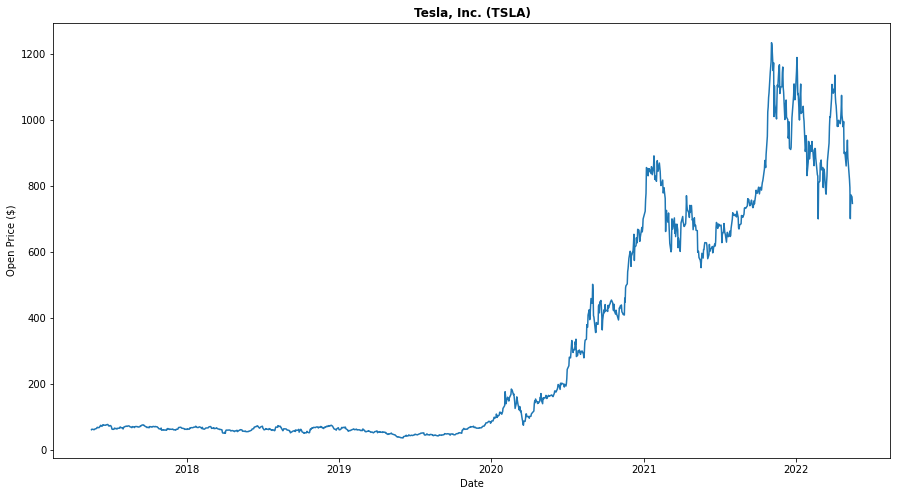

                                 ETS Results                                  
Dep. Variable:                      y   No. Observations:                 1259
Model:                      ETS(AAdN)   Log Likelihood               -5542.661
Date:                Wed, 18 May 2022   AIC                          11097.321
Time:                        14:45:07   BIC                          11128.150
Sample:                             0   HQIC                         11108.907
                               - 1259   Scale                          390.327
Covariance Type:               approx                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
smoothing_level     0.9061      0.038     23.687      0.000       0.831       0.981
smoothing_trend     0.0141      0.034      0.415      0.678      -0.052       0.080
damping_trend       0.8000      

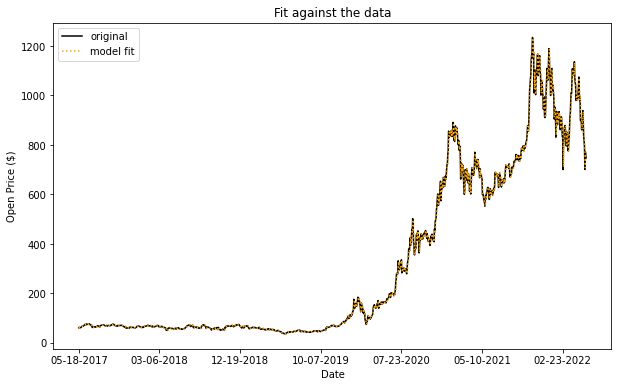

,mean,pi_lower,pi_upper
1259,748.421829,709.699415,787.144244
1260,747.836373,695.290312,800.382433
1261,747.368008,683.747176,810.988839
1262,746.993315,673.820960,820.165671
1263,746.693562,664.981029,828.406094
1264,746.453759,656.940169,835.967348
1265,746.261916,649.520645,843.003187
1266,746.108442,642.602643,849.614242
1267,745.985663,636.100473,855.870853
1268,745.887440,629.950156,861.824723


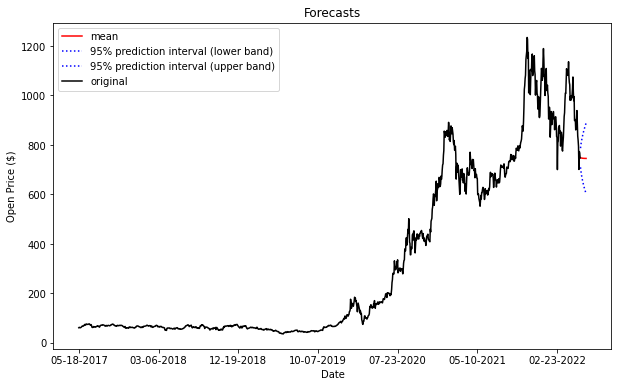

 
Number of missing data records from Open: 0
Number of missing data records from Close: 0
Number of missing data records from Date: 0


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2017-05-18 to 2022-05-17
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1259 non-null   float64
 1   High          1259 non-null   float64
 2   Low           1259 non-null   float64
 3   Close         1259 non-null   float64
 4   Volume        1259 non-null   int64  
 5   Dividends     1259 non-null   int64  
 6   Stock Splits  1259 non-null   float64
dtypes: float64(5), int64(2)
memory usage: 78.7 KB
None


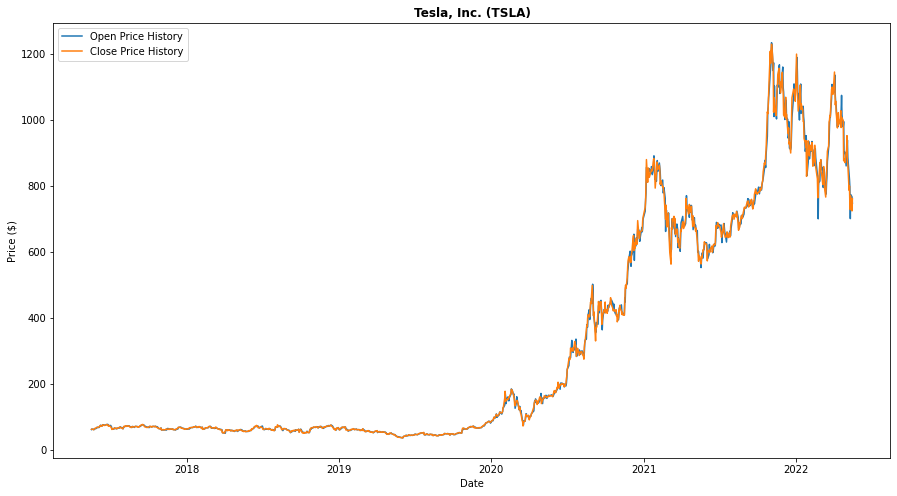

Predicted Closing Price for Tesla, Inc. -> $950.8727


Closing Price = 0.6833 + 0.9972 * Opening Price
The R^2: 0.997
The MAE: 8.4553


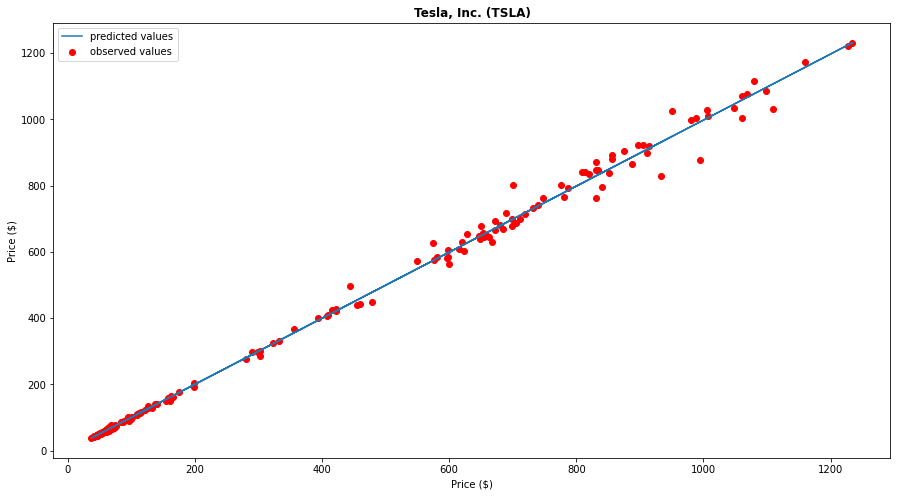

 
Number of missing data records from Open: 0
Number of missing data records from Date: 0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1259 non-null   datetime64[ns]
 1   Close   1259 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.8 KB
None


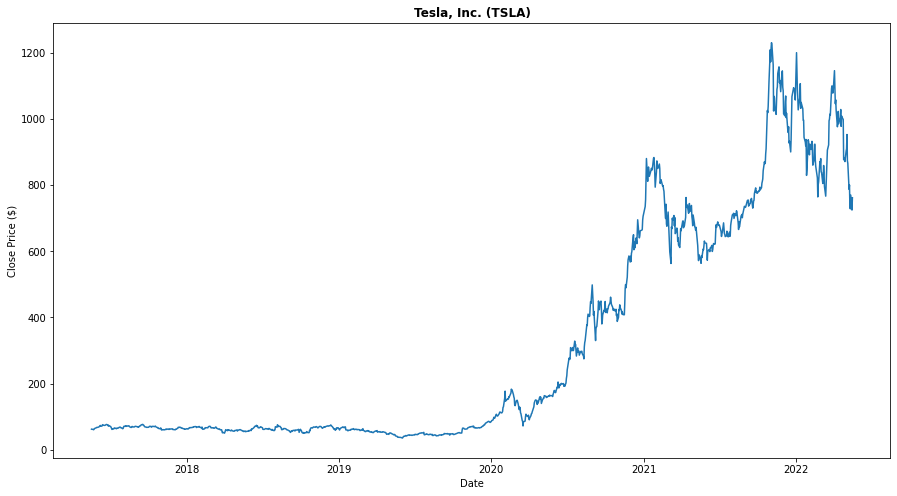

The null hypothesis (H0) is the data is NOT stationary


p-value = 0.8647
lags used = 21
num of obs = 1237


There is not enough evidence to reject the null and the data is NOT stationary


p-value = 0.0
lags used = 22
num of obs = 1224


There is significant evidence against the null, as a result H0 is rejected and the data after 1st differencing is stationary




<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1247
Model:               SARIMAX(2, 0, 3)   Log Likelihood               -5746.897
Date:                Wed, 18 May 2022   AIC                          11507.793
Time:                        14:45:54   BIC                          11543.693
Sample:                             0   HQIC                         11521.291
                               - 1247                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2238      0.168      1.328      0.184      -0.106       0.554
ar.L1          1.7992      0.026     69.903      0.000       1.749       1.850
ar.L2         -0.8300      0.023    -35.773      0.000      -0.875      -0.784
ma.L1         -0.8858      0.028    -31.335      0.000      -0.941      -0.830
ma.L2          0.0420      0.023      1.857      0.063      -0.002       0.086
ma.L3          0.0853      0.018      4.851      0.000       0.051       0.120
sigma2       588.5212     10.745     54.769      0.000     567.461     609.582
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):              3674.32
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):             185.26   Skew:                            -0.48
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

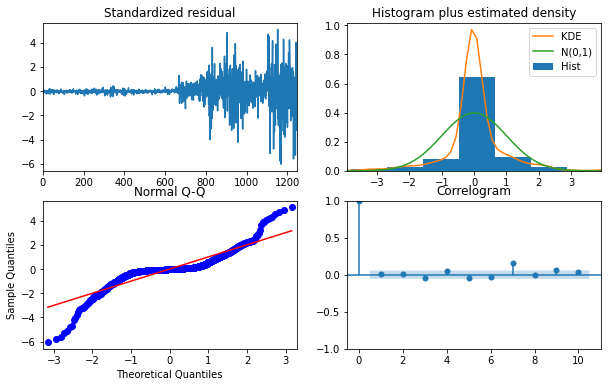

0    [-86.4540444663486, -68.151585524532, -48.9543...
1    [[-134.00170590350783, -38.906383029189385], [...
dtype: object

 
 
Stock: iShares Russell 2000 ETF
 
//////////////////////////////////////////////////////////////////////////////////////////////////////////////
 
Ticker Symbol: IWM
Type: Exchange Traded Fund (ETF)
Fund Family: iShares
Total Number of Assets: 54755041280
 
Summary: The fund generally invests at least 80% of its assets in the component securities of its underlying index and in investments that have economic characteristics that are substantially identical to the component securities of its underlying index (i.e., depositary receipts representing securities of the underlying index) and may invest up to 20% of its assets in certain futures, options and swap contracts, cash and cash equivalents.
 
//////////////////////////////////////////////////////////////////////////////////////////////////////////////
 
SYMBOL : HOLDING NAME : HOLDING PERCENT
 
AMC : AMC Entertainment Holdings Inc Class A : 0.0064999997
NTLA : Intellia Therapeutics Inc : 0.0037
CROX : Crocs Inc : 0.0031
LSCC : La

 
Number of missing data records from Open: 0
Number of missing data records from Date: 0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1259 non-null   datetime64[ns]
 1   Open    1259 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.8 KB
None


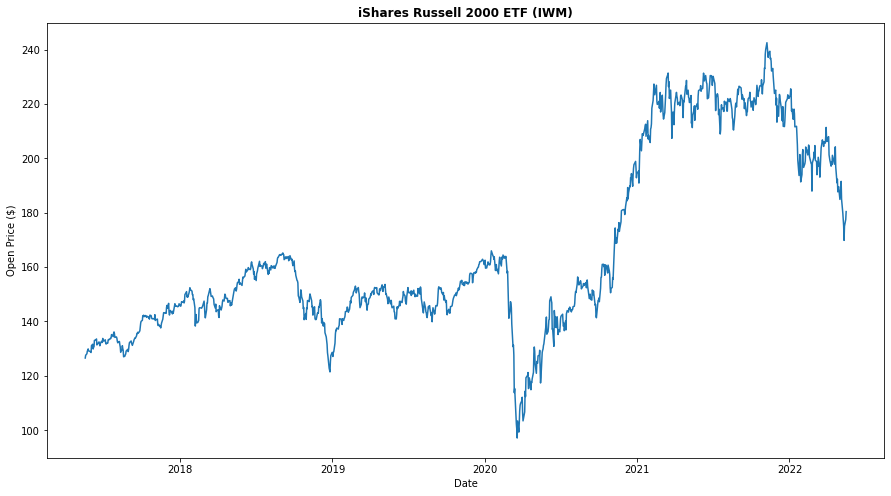

                                 ETS Results                                  
Dep. Variable:                      y   No. Observations:                 1259
Model:                      ETS(AAdN)   Log Likelihood               -2931.135
Date:                Wed, 18 May 2022   AIC                           5874.269
Time:                        14:46:06   BIC                           5905.098
Sample:                             0   HQIC                          5885.854
                               - 1259   Scale                            6.162
Covariance Type:               approx                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
smoothing_level     0.9420        nan        nan        nan         nan         nan
smoothing_trend     0.0150        nan        nan        nan         nan         nan
damping_trend       0.8000      

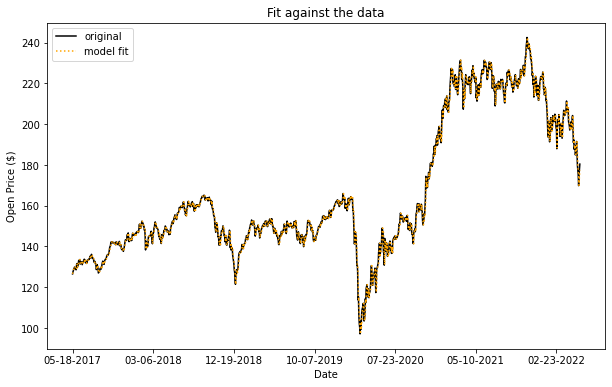

,mean,pi_lower,pi_upper
1259,180.248652,175.383332,185.113973
1260,180.263284,173.539116,186.987451
1261,180.274989,172.077873,188.472104
1262,180.284353,170.822733,189.745973
1263,180.291844,169.702471,190.881218
1264,180.297837,168.679959,191.915716
1265,180.302632,167.732891,192.872373
1266,180.306468,166.846580,193.766355
1267,180.309536,166.010704,194.608368
1268,180.311991,165.217649,195.406333


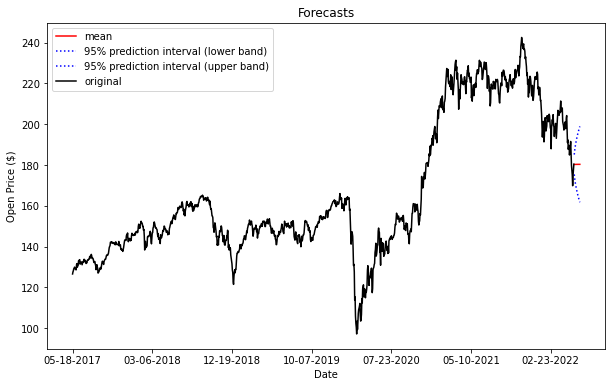

 
Number of missing data records from Open: 0
Number of missing data records from Close: 0
Number of missing data records from Date: 0


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2017-05-18 to 2022-05-17
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1259 non-null   float64
 1   High          1259 non-null   float64
 2   Low           1259 non-null   float64
 3   Close         1259 non-null   float64
 4   Volume        1259 non-null   int64  
 5   Dividends     1259 non-null   float64
 6   Stock Splits  1259 non-null   int64  
dtypes: float64(5), int64(2)
memory usage: 78.7 KB
None


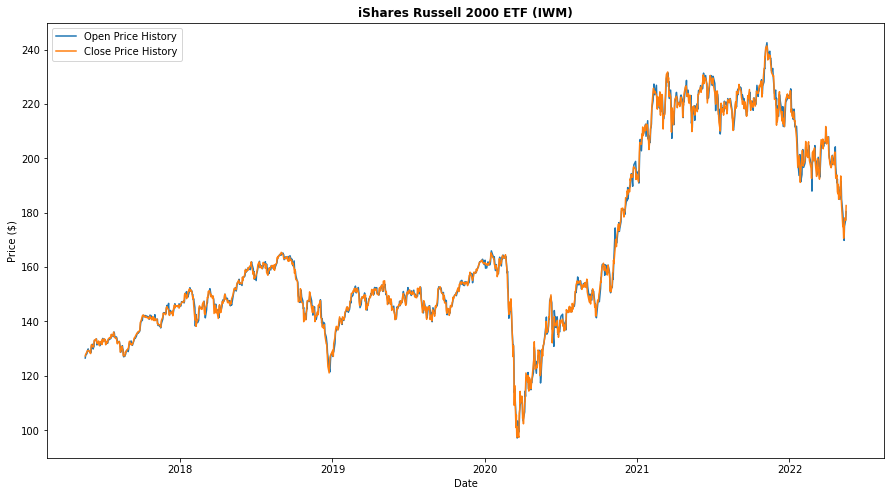

Predicted Closing Price for iShares Russell 2000 ETF -> $193.3232


Closing Price = 0.6244 + 0.9956 * Opening Price
The R^2: 0.9967
The MAE: 1.36


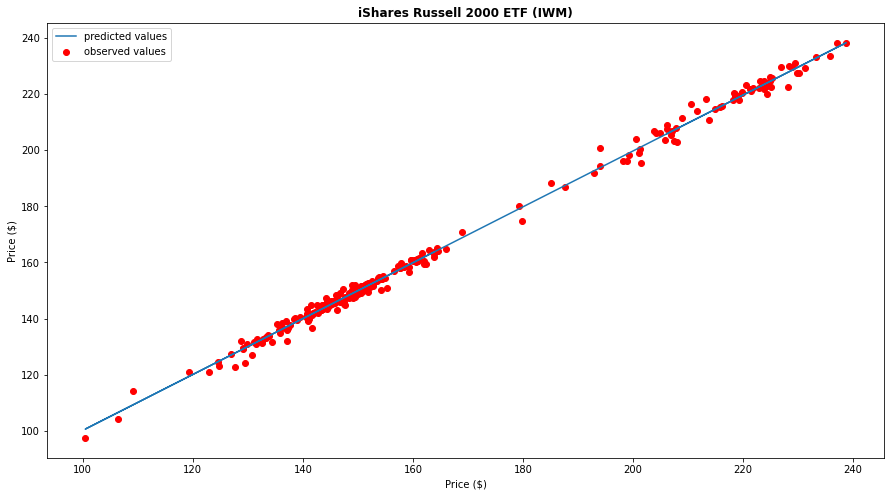

 
Number of missing data records from Open: 0
Number of missing data records from Date: 0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1259 non-null   datetime64[ns]
 1   Close   1259 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.8 KB
None


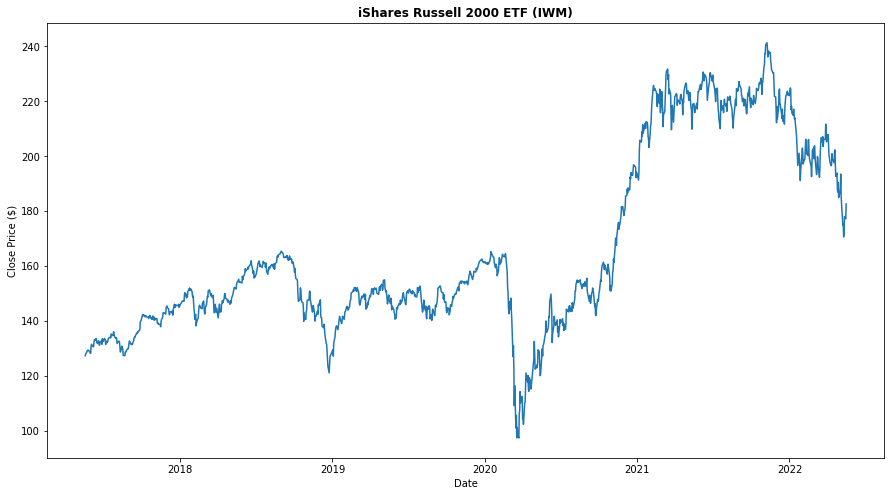

The null hypothesis (H0) is the data is NOT stationary


p-value = 0.5491
lags used = 9
num of obs = 1249


There is not enough evidence to reject the null and the data is NOT stationary


p-value = 0.0
lags used = 21
num of obs = 1225


There is significant evidence against the null, as a result H0 is rejected and the data after 1st differencing is stationary




<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1247
Model:               SARIMAX(2, 0, 2)   Log Likelihood               -3260.362
Date:                Wed, 18 May 2022   AIC                           6532.725
Time:                        14:46:45   BIC                           6563.496
Sample:                             0   HQIC                          6544.294
                               - 1247                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0128      0.019      0.664      0.506      -0.025       0.051
ar.L1          1.7982      0.051     35.578      0.000       1.699       1.897
ar.L2         -0.8220      0.045    -18.268      0.000      -0.910      -0.734
ma.L1         -0.9098      0.058    -15.693      0.000      -1.023      -0.796
ma.L2          0.1032      0.025      4.146      0.000       0.054       0.152
sigma2        10.9103      0.300     36.420      0.000      10.323      11.497
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               329.50
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               4.52   Skew:                            -0.30
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

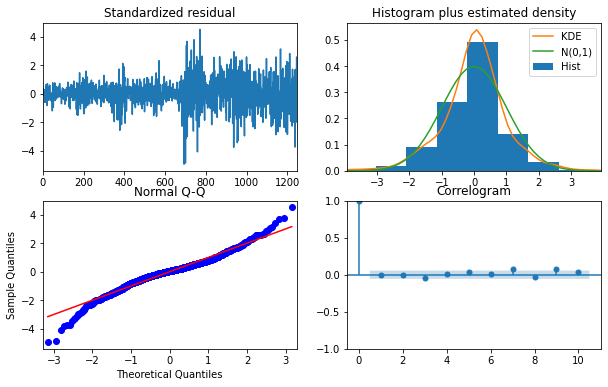

0    [-1.5596750145779081, -0.018596740591751038, 1...
1    [[-8.033588704237584, 4.914238675081768], [-8....
dtype: object

In [43]:
# all calls and input requests for the user

# user enters number of stocks to see 
how_many = input('Enter how many stocks: ')

# creates an array that will hold user input for ticker symbols 
list_of_tickers = []
for h in range(int(how_many)):
    input_ticker = input('Enter ticker symbol: ')
    list_of_tickers.append(input_ticker.upper())

# presentation info
print('The tool will be run for ' + str(how_many) + ' stock/s')
print('The stock/s -> ' + str(list_of_tickers))
print('\n')

# function calls 
for call_num in range(len(list_of_tickers)):
    df_, df, df_volume, name, ticker_symbol, ticker, raw_dataset = get_and_prep_dataset(list_of_tickers = list_of_tickers, call_num = call_num)
    get_company_info(ticker)
    show_visual(df_, df, df_volume, name, ticker_symbol)
    print(' ')

    # ets model
    see_data(df_)
    secondary_visualizations(df_, ticker)    
    the_etsmodel(df_)
    print(' ')

    # linear regression model
    see_data_lr(raw_dataset, df_)    
    secondary_visualizations_lr(raw_dataset, df_, ticker)
    lreg_model(raw_dataset, ticker)
    print(' ')

    # arima model
    see_data_ar(df)
    secondary_visualizations_ar(df, ticker)
    the_arima(df)
    print(' ')
    